In [16]:
import math
import warnings

from IPython.display import display
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import linear_model
import statsmodels.formula.api as smf
from scipy.stats import mstats
import statsmodels.api as sm
from scipy.stats import boxcox
from scipy.special import inv_boxcox
from sklearn.cross_decomposition import PLSRegression

# Display preferences.
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format

# Suppress annoying harmless error.
warnings.filterwarnings(
    action="ignore",
    module="scipy",
    message="^internal gelsd"
)

In [2]:
df = pd.read_excel('./florida_2017.xls')
headers = ['city', 'population', 'violent_crime', 'murder', 'rape', 'robbery',
       'assault', 'property_crime', 'burglary', 'larceny_theft',
       'motor_vehicle_theft', 'arson']
df.columns = headers
df.set_index('city', inplace=True)

crime_cols = ['violent_crime', 'murder', 'rape', 'robbery', 
              'assault', 'property_crime', 'burglary', 'larceny_theft', 
              'motor_vehicle_theft', 'arson']

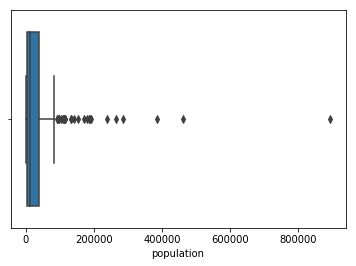

In [3]:
sns.boxplot(df.population)

In [3]:
cols = ['violent_crime', 'murder', 'rape', 'robbery', 
        'assault', 'burglary', 'larceny_theft', 
        'motor_vehicle_theft', 'arson']
df["log_odds"] = np.log1p(df.population / df[cols].sum(axis=1))

In [4]:
# so we will want to remove some outliers
df = df[df.population<df.population.quantile(0.9)]

# log population
df["population_log"] = np.log(df.population)
# log1p first adds 1 to x then logs the result
df["property_crime_log"] = np.log1p(df.property_crime)
# square population
df["population_squared"] = df.population**2
df["population_cube_root"] = df.population**(1/3)
# create robbery dummy var
df["has_robbery"] = np.where(df.robbery>0,1,0)

# because box-cox transforms require x>0, when property_crime is 0 we add 1, else we leave it alone
df["property_crime_2"] = df["property_crime"].apply(lambda x: x+1 if x == 0 else x)


df["population_group"] = pd.cut(df.population, 5, labels=list(range(1,6)))
groups = list(df.groupby("population_group")["log_odds"].mean().values)
df["log_odds_group"] = pd.cut(df.log_odds, 5, labels=groups)

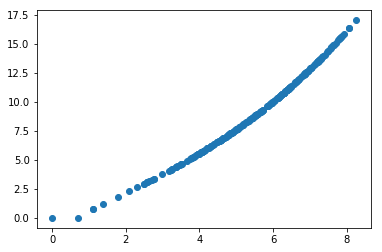

In [5]:
bc = boxcox(df["property_crime_2"])
df['property_crime_bc'] = bc[0]
bc_lambda = bc[1]

plt.scatter(df["property_crime_log"], bc[0])
plt.show()

In [6]:
df.skew()

population              1.351
violent_crime           2.825
murder                  4.326
rape                    2.413
robbery                 3.483
assault                 3.108
property_crime          1.987
burglary                1.883
larceny_theft           1.998
motor_vehicle_theft     2.768
arson                   2.211
log_odds                0.606
population_log         -0.386
property_crime_log     -0.585
population_squared      2.300
population_cube_root    0.379
has_robbery            -1.509
property_crime_2        1.987
population_group        1.501
log_odds_group          1.083
property_crime_bc      -0.049
dtype: float64

/Users/mitchellmurphy/anaconda3/envs/python3.5/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


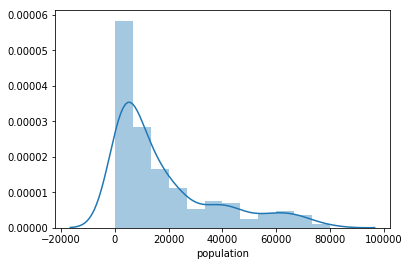

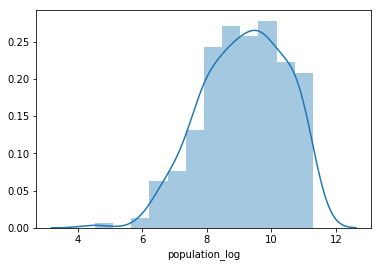

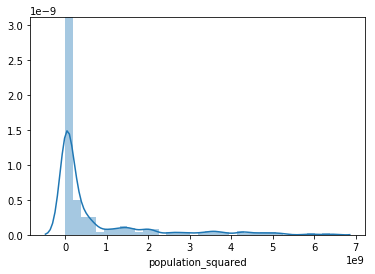

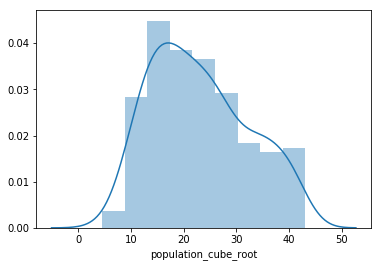

In [7]:
sns.distplot(df.population)
plt.show()
sns.distplot(df.population_log)
plt.show()
sns.distplot(df.population_squared)
plt.show()
sns.distplot(df.population_cube_root)
plt.show()

*Cube root of population looks to be the best to use in place of population.*

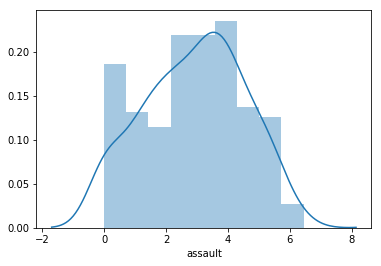

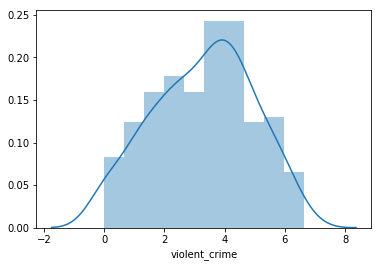

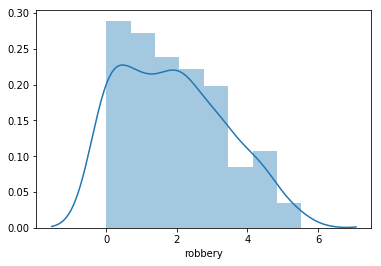

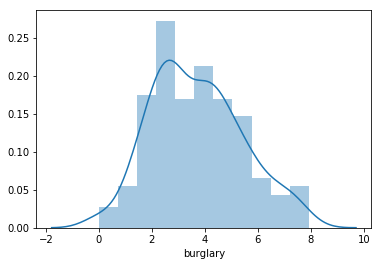

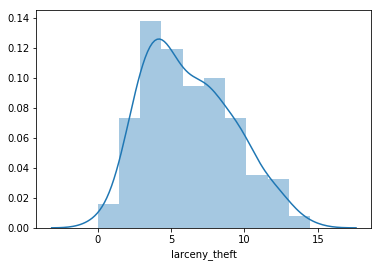

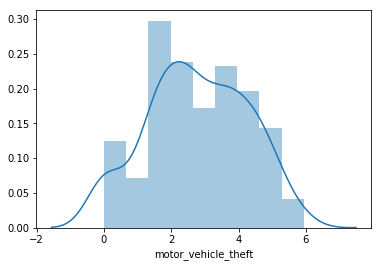

In [8]:
# split into population groups
df["population_low"] = (df.population < 3620.0).astype("int")
df["population_medium"] = (df.population.between(3620.0, 24929.5)).astype("int")
df["population_high"] = (df.population >= 24929.5).astype("int")

sns.distplot(np.log1p(df.assault))
df["assault_log"] = np.log1p(df.assault)
plt.show()
sns.distplot(np.log1p(df.violent_crime))
df["violent_crime_log"] = np.log1p(df.violent_crime)
plt.show()
sns.distplot(np.log1p(df.robbery))
df["robbery_log"] = np.log1p(df.robbery) 
plt.show()
sns.distplot(df.burglary**(1/3))
df["burglary_cube_root"] = df.burglary**(1/3)
plt.show()
sns.distplot(df.larceny_theft**(1/3))
df["larceny_theft_cube_root"] = df.larceny_theft**(1/3)
plt.show()
sns.distplot(np.log1p(df.motor_vehicle_theft))
df["motor_vehicle_theft_log"] = np.log1p(df.motor_vehicle_theft)
plt.show()

df["murder_log"] = np.log1p(df.murder)

# Split

In [9]:
train = df.sample(frac=0.7, random_state=41)
test_cities = list(set(df.index).difference(set(train.index)))
test = df.loc[test_cities,:]
print("Train shape: {}".format(train.shape))
print("Test shape: {}".format(test.shape))

Train shape: (178, 31)
Test shape: (77, 31)


# Models

In [10]:
model_vars = ['population_log', "population_group",
              "burglary_cube_root", "log_odds", 
              "larceny_theft_cube_root"]

formula1 = "property_crime ~ " + ' + '.join(model_vars)
lm1 = smf.ols(formula=formula1, data=train).fit()
lm1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         property_crime   R-squared:                       0.958
Model:                            OLS   Adj. R-squared:                  0.956
Method:                 Least Squares   F-statistic:                     484.3
Date:                Fri, 14 Dec 2018   Prob (F-statistic):          2.89e-112
Time:                        01:08:29   Log-Likelihood:                -1141.1
No. Observations:                 178   AIC:                             2300.
Df Residuals:                     169   BIC:                             2329.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 944.1455    172.808      5.464      0.000     603.005    1285.286
population_group[T.2]     -51.8501     46.477     -1.116      0.266    -143.600      39.900
population_group[T.3]      48.3004     59.801      0.808      0.420     -69.753     166.354
population_group[T.4]     177.6957     75.285      2.360      0.019      29.075     326.316
population_group[T.5]     449.8661     84.571      5.319      0.000     282.914     616.818
population_log           -506.0889     33.261    -15.216      0.000    -571.750    -440.428
burglary_cube_root        197.8263     20.902      9.465      0.000     156.565     239.088
log_odds                  410.2488     37.798     10.854      0.000     335.631     484.866
larceny_theft_cube_root   323.0913     17.076     18.921      0.000     289.382     356.801
==============================================================================
Omnibus:                       34.969   Durbin-Watson:                   2.037
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              128.040
Skew:                           0.680   Prob(JB):                     1.57e-28
Kurtosis:                       6.926   Cond. No.                         207.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [11]:
model_vars2 = ['population_log', 'has_robbery', "population_group",
              "robbery_log", "burglary_cube_root",
              "larceny_theft_cube_root", "motor_vehicle_theft_log"]

formula2 = "property_crime_log ~ " + ' + '.join(model_vars2)
lm2 = smf.ols(formula=formula2, data=train).fit()
lm2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     property_crime_log   R-squared:                       0.978
Model:                            OLS   Adj. R-squared:                  0.977
Method:                 Least Squares   F-statistic:                     751.0
Date:                Fri, 14 Dec 2018   Prob (F-statistic):          3.19e-133
Time:                        01:08:32   Log-Likelihood:                 3.6908
No. Observations:                 178   AIC:                             14.62
Df Residuals:                     167   BIC:                             49.62
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  -0.4245      0.284     -1.493      0.137      -0.986       0.137
population_group[T.2]      -0.2758      0.073     -3.753      0.000      -0.421      -0.131
population_group[T.3]      -0.6216      0.087     -7.104      0.000      -0.794      -0.449
population_group[T.4]      -0.9505      0.104     -9.159      0.000      -1.155      -0.746
population_group[T.5]      -1.0757      0.117     -9.172      0.000      -1.307      -0.844
population_log              0.2971      0.041      7.287      0.000       0.217       0.378
has_robbery                 0.4423      0.063      7.028      0.000       0.318       0.567
robbery_log                -0.1791      0.035     -5.116      0.000      -0.248      -0.110
burglary_cube_root          0.2068      0.032      6.405      0.000       0.143       0.271
larceny_theft_cube_root     0.3598      0.023     15.767      0.000       0.315       0.405
motor_vehicle_theft_log     0.1123      0.034      3.280      0.001       0.045       0.180
==============================================================================
Omnibus:                       44.910   Durbin-Watson:                   1.934
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              112.219
Skew:                          -1.070   Prob(JB):                     4.29e-25
Kurtosis:                       6.248   Cond. No.                         209.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [12]:
# Now lets see how well we can predict the boxcox transform of property_crime

model_vars3 = ['has_robbery', "population_group",
              'population_medium', "log_odds",
              "robbery_log", "burglary_cube_root",
              "larceny_theft_cube_root", "motor_vehicle_theft_log"]


formula3 = "property_crime_bc ~ " + ' + '.join(model_vars3)
lm3 = smf.ols(formula=formula3, data=train).fit()
lm3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      property_crime_bc   R-squared:                       0.994
Model:                            OLS   Adj. R-squared:                  0.994
Method:                 Least Squares   F-statistic:                     2473.
Date:                Fri, 14 Dec 2018   Prob (F-statistic):          8.79e-178
Time:                        01:08:33   Log-Likelihood:                -34.552
No. Observations:                 178   AIC:                             93.10
Df Residuals:                     166   BIC:                             131.3
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                   1.9808      0.329      6.025      0.000       1.332       2.630
population_group[T.2]       0.1906      0.104      1.842      0.067      -0.014       0.395
population_group[T.3]       0.3660      0.171      2.136      0.034       0.028       0.704
population_group[T.4]       0.1085      0.205      0.529      0.597      -0.296       0.513
population_group[T.5]       0.0436      0.224      0.195      0.846      -0.398       0.486
has_robbery                 0.4617      0.080      5.774      0.000       0.304       0.620
population_medium           0.4617      0.073      6.321      0.000       0.318       0.606
log_odds                   -0.2487      0.064     -3.913      0.000      -0.374      -0.123
robbery_log                -0.2300      0.043     -5.371      0.000      -0.314      -0.145
burglary_cube_root          0.4340      0.040     10.883      0.000       0.355       0.513
larceny_theft_cube_root     0.8730      0.030     28.938      0.000       0.813       0.933
motor_vehicle_theft_log     0.2188      0.043      5.141      0.000       0.135       0.303
==============================================================================
Omnibus:                       41.096   Durbin-Watson:                   2.121
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              111.345
Skew:                          -0.944   Prob(JB):                     6.63e-25
Kurtosis:                       6.384   Cond. No.                         190.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Whoa** this looks even better than the second model! We store the value of lambda for the Box-Cox transform so that we can reverse it using [this](https://docs.scipy.org/doc/scipy/reference/generated/scipy.special.inv_boxcox.html).

## PLSR

In [13]:
model_vars = ['population_log', 'has_robbery', 
              'population_medium',
              "robbery_log", "burglary_cube_root",
              "larceny_theft_cube_root", "motor_vehicle_theft_log"]

X_train = train[model_vars]
y_train = train["property_crime_bc"]
X_test = test[model_vars]
y_test = test["property_crime_bc"]

In [14]:
def evaluate_pslr_model(X, y, n_components):
    # Fit a linear model with all 10 features.
    regr = linear_model.LinearRegression()
    regr.fit(X, y)
    # Fit a linear model using Partial Least Squares Regression.
    # Reduce feature space to 3 dimensions.
    pls1 = PLSRegression(n_components=n_components)

    # Reduce X to R(X) and regress on y.
    pls1.fit(X, y)

    # Save predicted values.
    Y_PLS_pred = pls1.predict(X)
    print('R-squared PLSR:', pls1.score(X, y))
    return Y_PLS_pred

In [40]:
print("EVALUATION\n\n\nTrain\n***********************\n")

Y_PLS_pred_train = evaluate_pslr_model(X_train, y_train, 3)
predicted_pls_train = pd.DataFrame(inv_boxcox(Y_PLS_pred_train, bc_lambda), columns=["predicted"])
residuals_pls_train = predicted_pls_train["predicted"].values - train["property_crime"].values
print("Average Error: {}".format(residuals_pls_train.mean()))
print("RMSE: {}".format(residuals_pls_train.std()))

print("EVALUATION\n\n\nTest\n***********************\n")

Y_PLS_pred_test = evaluate_pslr_model(X_test, y_test, 3)
predicted_pls_test = pd.DataFrame(inv_boxcox(Y_PLS_pred_test, bc_lambda), columns=["predicted"])
residuals_pls_test = predicted_pls_test["predicted"].values - test["property_crime"].values
print("Average Error: {}".format(residuals_pls_test.mean()))
print("RMSE: {}".format(residuals_pls_test.std()))

EVALUATION


Train
***********************

R-squared PLSR: 0.9859791077255515
Average Error: 20.527359416875104
RMSE: 130.84209686363732
EVALUATION


Test
***********************

R-squared PLSR: 0.9787835486972543
Average Error: 7.850768660334454
RMSE: 75.80316599679696


**This is the model we want to go with, but let's look further into this model's performance to identify places where it fails (look at the residuals).**

/Users/mitchellmurphy/anaconda3/envs/python3.5/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


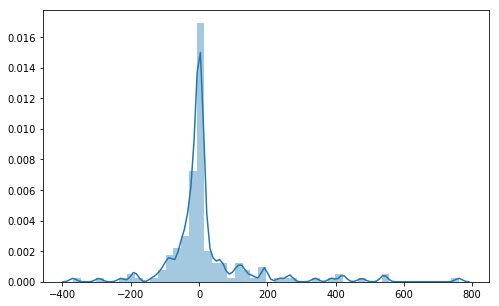

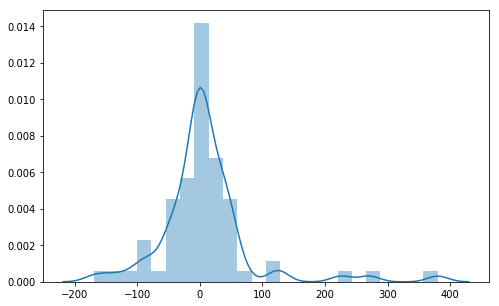

In [44]:
plt.figure(figsize=(8,5))
sns.distplot(residuals_train)
plt.show()
plt.figure(figsize=(8,5))
sns.distplot(residuals_test)
plt.show()

This visually shows the reduction in RMSE from the train set to the test set. This is a rather drastic decrease, so cross validation needs to be done here.

In [45]:
train["residuals_pls_train"] = residuals_pls_train
test["residuals_pls_test"] = residuals_pls_test
train["percent_off_pls"] = train["residuals_train"] / train["property_crime"]
train["error_group_pls"] = pd.cut(train.percent_off_pls, 10)

test["percent_off_pls"] = test["residuals_pls_test"] / test["property_crime"]
# need to replace NaN with 0
test.percent_off_pls.replace(np.nan, 0.0, inplace=True)

# infinity values need to be replaced with the residual
test.percent_off_pls = test.apply(
    lambda row: row["residuals_pls_test"] if np.isinf(row["percent_off_pls"]) else row["percent_off_pls"],
    axis=1
)
test["error_group_pls"] = pd.cut(test.percent_off_pls, 10)
test.groupby("error_group_pls").mean()

,population,violent_crime,murder,rape,robbery,assault,property_crime,burglary,larceny_theft,motor_vehicle_theft,...,larceny_theft_cube_root,motor_vehicle_theft_log,murder_log,residuals_test,percent_off,residuals1_test,residuals2_test,residuals3_test,residuals_pls_test,percent_off_pls
error_group_pls,,,,,,,,,,,,,,,,,,,,,
"(-0.432, -0.0937]",11282.895,33.474,0.316,3.737,5.474,23.947,307.421,40.053,250.842,16.526,...,5.716,2.298,0.204,-59.944,-0.236,-35.604,22.683,23.327,-59.944,-0.236
"(-0.0937, 0.241]",19021.426,82.021,0.830,5.766,19.128,56.298,532.872,90.064,403.085,39.723,...,6.596,3.241,0.381,33.232,0.043,23.241,-77.293,-27.846,33.232,0.043
"(0.241, 0.576]",7664.875,9.375,0.000,1.750,1.500,6.125,72.000,14.000,51.875,6.125,...,3.459,1.751,0.000,21.118,0.301,90.034,-5.605,0.916,21.118,0.301
"(0.576, 0.911]",769.500,0.000,0.000,0.000,0.000,0.000,7.000,2.000,3.500,1.500,...,1.409,0.693,0.000,4.840,0.672,-422.608,-3.813,-3.747,4.840,0.672
"(0.911, 1.246]",nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
"(1.246, 1.581]",nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
"(1.581, 1.915]",nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
"(1.915, 2.25]",nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
"(2.25, 2.585]",nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


### Conclusion

From this it is apparent that this model struggles the most when dealing with rural cities (population around 1237). This is confirmed via the performance on the test set (as seen above), this time the model achieves around 1.75% error on cities with a population under 1000. My suggestion is to use a separate model for lower populated areas, another for medium to high populations and one more for very high populated cities. 

# Evaluate

In [46]:
# Model 1
predicted1_train = lm1.fittedvalues
residuals1_train = train["property_crime"] - predicted1_train
predicted1_test = lm1.predict(test)
residuals1_test = test["property_crime"] - predicted1_test

# Model 2
predicted2_train = np.exp(lm2.fittedvalues)
residuals2_train = train["property_crime"] - predicted2_train
predicted2_test = np.exp(lm2.predict(test))
residuals2_test = test["property_crime"] - predicted2_test

# Model 3
predicted3_train = inv_boxcox(lm3.fittedvalues, bc_lambda)
residuals3_train = train["property_crime"] - predicted3_train
predicted3_test = inv_boxcox(lm3.predict(test), bc_lambda)
residuals3_test = test["property_crime"] - predicted3_test

In [49]:
# add them to the train dataframe for later analysis
train["residuals1_train"] = residuals1_train
train["residuals2_train"] = residuals2_train
train["residuals3_train"] = residuals3_train

test["residuals1_test"] = residuals1_test
test["residuals2_test"] = residuals2_test
test["residuals3_test"] = residuals3_test

cols1 = ["residuals1_train","residuals2_train", "residuals3_train", "residuals_pls_train"]
cols2 = ["residuals1_test", "residuals2_test", "residuals3_test", "residuals_pls_test"]

In [50]:
test.groupby("population_group")[cols2].std()

,residuals1_test,residuals2_test,residuals3_test,residuals_pls_test
population_group,,,,
1,156.901,47.847,16.068,31.492
2,86.520,82.668,54.100,65.579
3,130.113,669.322,279.385,127.127
4,nan,nan,nan,nan
5,266.955,165.272,182.090,220.001


/Users/mitchellmurphy/anaconda3/envs/python3.5/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


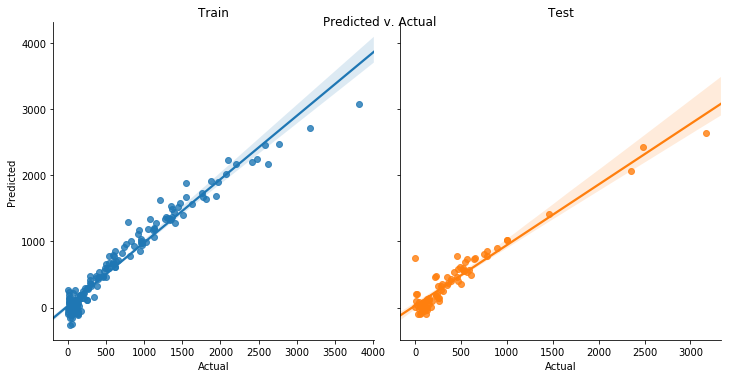

In [51]:
fig, (ax1, ax2) = plt.subplots(1,2, sharey=True)
fig.set_figheight(5)
fig.set_figwidth(10)
fig.tight_layout()
fig.suptitle("Predicted v. Actual")
sns.regplot(train["property_crime"], lm1.fittedvalues, ax=ax1)
ax1.set_title("Train")
sns.despine(ax=ax1)

sns.regplot(test["property_crime"], predicted1_test, ax=ax2)
ax1.set(xlabel="Actual", ylabel="Predicted")
sns.despine(ax=ax2)
ax2.set_xlabel("Actual")
ax2.set_title("Test")
plt.show()

*Remember that for model 2 that we are predicting the log of property crime, so we need to exponentiate the predicted values.*

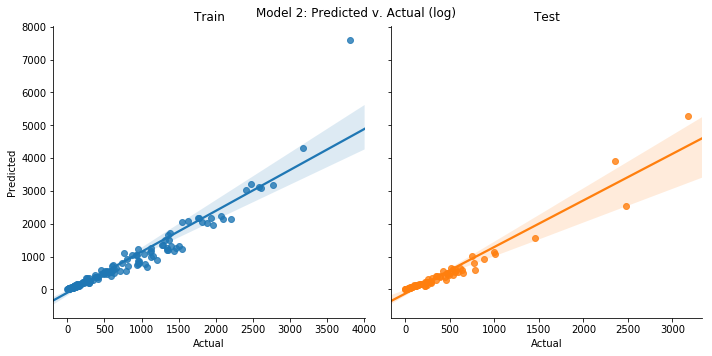

In [52]:
fig, (ax1, ax2) = plt.subplots(1,2, sharey=True)
fig.set_figheight(5)
fig.set_figwidth(10)
fig.suptitle("Model 2: Predicted v. Actual (log)")
sns.regplot(train["property_crime"], predicted2_train, ax=ax1)
ax1.set_title("Train")
sns.despine(ax=ax1)

sns.regplot(test["property_crime"], predicted2_test, ax=ax2)
ax1.set(xlabel="Actual", ylabel="Predicted")
sns.despine(ax=ax2)
ax2.set_xlabel("Actual")
ax2.set_title("Test")
fig.tight_layout()
plt.show()

/Users/mitchellmurphy/anaconda3/envs/python3.5/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


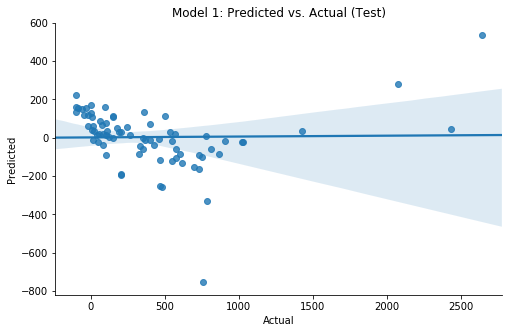

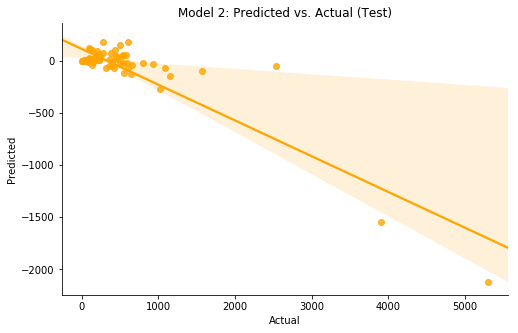

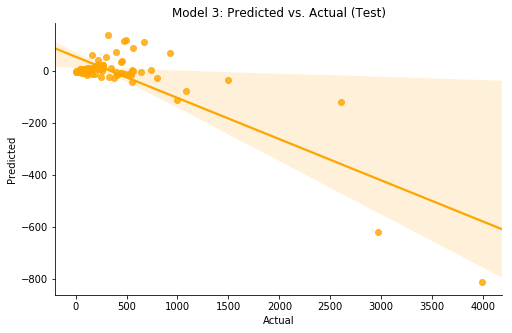

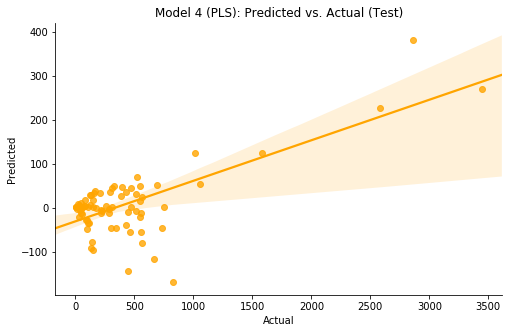

In [54]:
plt.figure(figsize=(8,5))
sns.regplot(predicted1_test, residuals1_test, fit_reg = True)
plt.xlabel("Actual")
plt.ylabel("Predicted")
sns.despine()
plt.title("Model 1: Predicted vs. Actual (Test)")
plt.show()

plt.figure(figsize=(8,5))
sns.regplot(predicted2_test, residuals2_test, fit_reg = True, color="orange")
plt.xlabel("Actual")
plt.ylabel("Predicted")
sns.despine()
plt.title("Model 2: Predicted vs. Actual (Test)")
plt.show()

plt.figure(figsize=(8,5))
sns.regplot(predicted3_test, residuals3_test, fit_reg = True, color="orange")
plt.xlabel("Actual")
plt.ylabel("Predicted")
sns.despine()
plt.title("Model 3: Predicted vs. Actual (Test)")
plt.show()

plt.figure(figsize=(8,5))
sns.regplot(predicted_pls_test, residuals_pls_test, fit_reg = True, color="orange")
plt.xlabel("Actual")
plt.ylabel("Predicted")
sns.despine()
plt.title("Model 4 (PLS): Predicted vs. Actual (Test)")
plt.show()

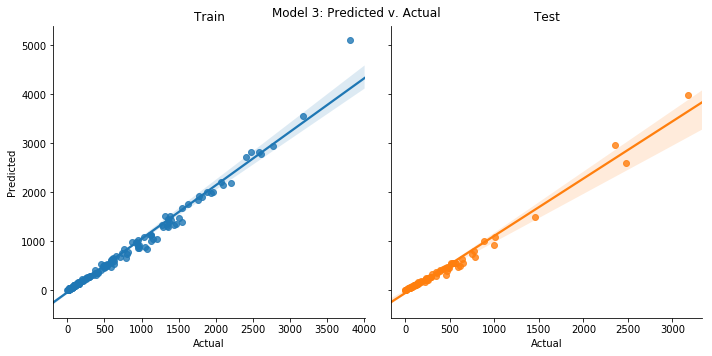

In [55]:
fig, (ax1, ax2) = plt.subplots(1,2, sharey=True)
fig.set_figheight(5)
fig.set_figwidth(10)
fig.suptitle("Model 3: Predicted v. Actual")
sns.regplot(train["property_crime"], predicted3_train, ax=ax1)
ax1.set_title("Train")
sns.despine(ax=ax1)

sns.regplot(test["property_crime"], predicted3_test, ax=ax2)
ax1.set(xlabel="Actual", ylabel="Predicted")
sns.despine(ax=ax2)
ax2.set_xlabel("Actual")
ax2.set_title("Test")
fig.tight_layout()
plt.show()

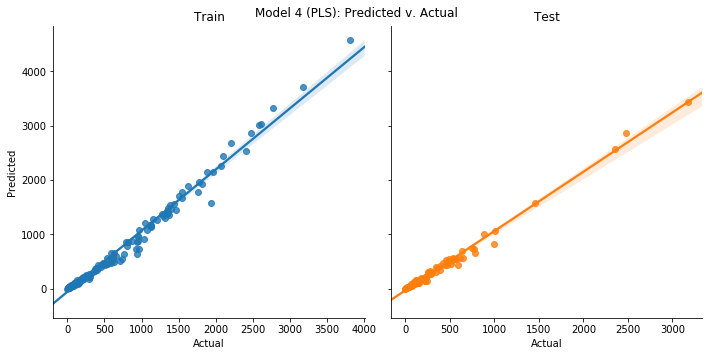

In [75]:
fig, (ax1, ax2) = plt.subplots(1,2, sharey=True)
fig.set_figheight(5)
fig.set_figwidth(10)
fig.suptitle("Model 4 (PLS): Predicted v. Actual")
sns.regplot(train["property_crime"], predicted_pls_train.values.reshape(178,), ax=ax1)
ax1.set_title("Train")
sns.despine(ax=ax1)

sns.regplot(test["property_crime"], predicted_pls_test.values.reshape(77,), ax=ax2)
ax1.set(xlabel="Actual", ylabel="Predicted")
sns.despine(ax=ax2)
ax2.set_xlabel("Actual")
ax2.set_title("Test")
fig.tight_layout()
plt.show()

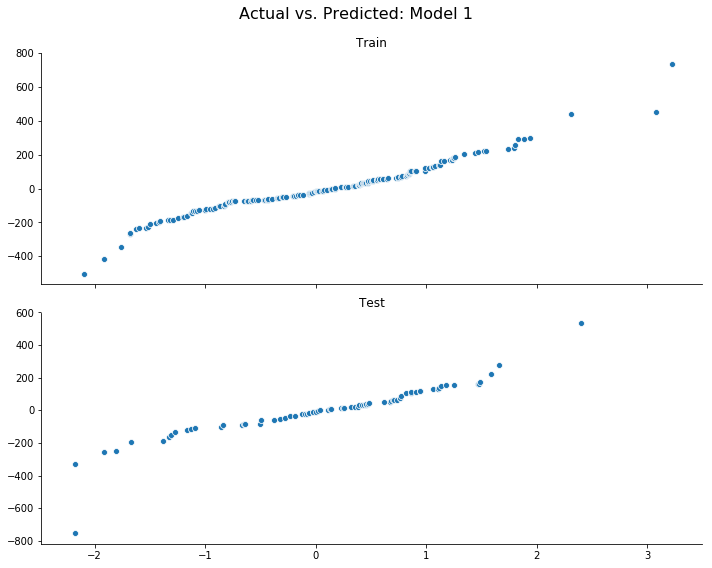

In [76]:
fig, (ax1, ax2) = plt.subplots(2,1,sharex=True)
fig.set_figheight(8)
fig.set_figwidth(10)
fig.suptitle("Actual vs. Predicted: Model 1",  size=16)

norm_train = np.random.normal(0,1,len(residuals1_train))
norm_test = np.random.normal(0,1,len(residuals1_test))
norm_train.sort()
norm_test.sort()
residuals1_train.values.sort()
residuals1_test.values.sort()

sns.scatterplot(norm_train, residuals1_train, ax=ax1)
sns.despine(ax=ax1)
ax1.set_title("Train")

sns.scatterplot(norm_test, residuals1_test, ax=ax2)
sns.despine(ax=ax2)
ax2.set_title("Test")
plt.tight_layout()
plt.subplots_adjust(top=.9)
plt.show()

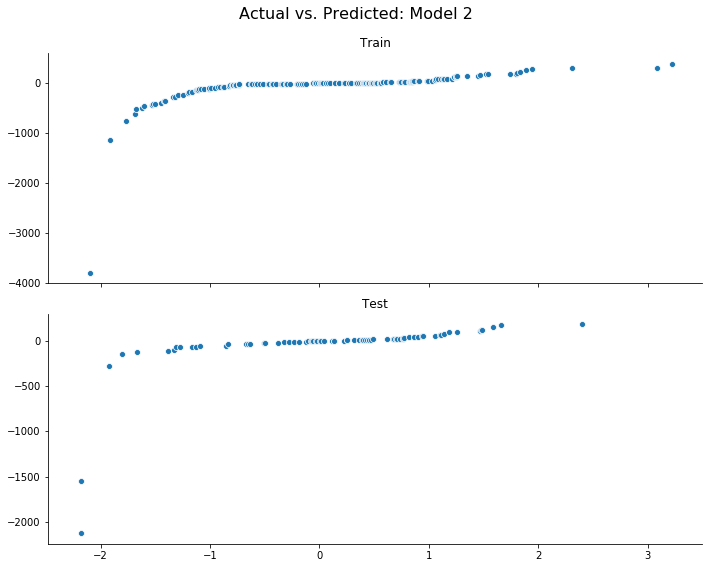

In [77]:
fig, (ax1, ax2) = plt.subplots(2,1,sharex=True)
fig.set_figheight(8)
fig.set_figwidth(10)
fig.suptitle("Actual vs. Predicted: Model 2",  size=16)

residuals2_train.values.sort()
residuals2_test.values.sort()

sns.scatterplot(norm_train, residuals2_train, ax=ax1)
sns.despine(ax=ax1)
ax1.set_title("Train")
sns.scatterplot(norm_test, residuals2_test, ax=ax2)
ax2.set_title("Test")
sns.despine(ax=ax2)

plt.tight_layout()
plt.subplots_adjust(top=.9)
plt.show()

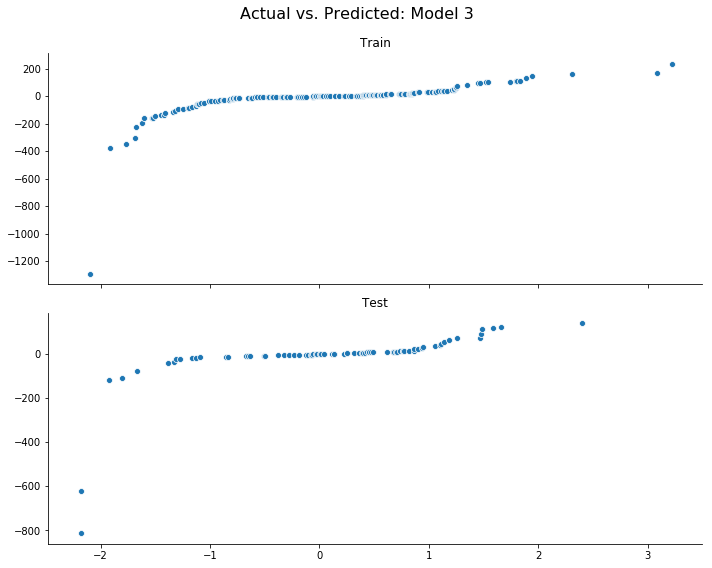

In [78]:
fig, (ax1, ax2) = plt.subplots(2,1,sharex=True)
fig.set_figheight(8)
fig.set_figwidth(10)
fig.suptitle("Actual vs. Predicted: Model 3",  size=16)

residuals3_train.values.sort()
residuals3_test.values.sort()

sns.scatterplot(norm_train, residuals3_train, ax=ax1)
sns.despine(ax=ax1)
ax1.set_title("Train")
sns.scatterplot(norm_test, residuals3_test, ax=ax2)
ax2.set_title("Test")
sns.despine(ax=ax2)

plt.tight_layout()
plt.subplots_adjust(top=.9)
plt.show()

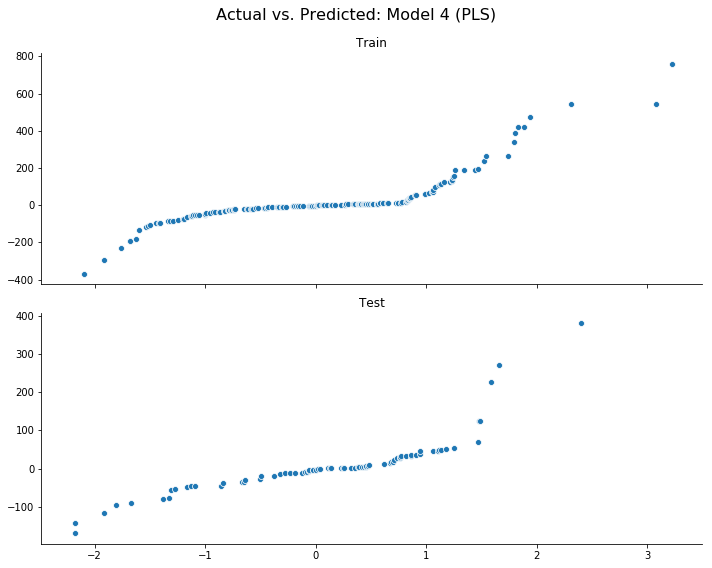

In [82]:
fig, (ax1, ax2) = plt.subplots(2,1,sharex=True)
fig.set_figheight(8)
fig.set_figwidth(10)
fig.suptitle("Actual vs. Predicted: Model 4 (PLS)",  size=16)

residuals_pls_train.sort()
residuals_pls_test.sort()

sns.scatterplot(norm_train, residuals_pls_train, ax=ax1)
sns.despine(ax=ax1)
ax1.set_title("Train")
sns.scatterplot(norm_test, residuals_pls_test, ax=ax2)
ax2.set_title("Test")
sns.despine(ax=ax2)

plt.tight_layout()
plt.subplots_adjust(top=.9)
plt.show()

From the look of these QQ plots, model 1 and 4 look to be the most normal. 

In [83]:
print("--------------------\nMODEL 1\n--------------------\nr^2: 0.973")
print("\nTRAIN\n********************")
print("Mean Residual: {}".format(lm1.resid.mean()))
print("RMSE: {}".format(round(lm1.resid.std()),2))
print("\nTEST\n********************")
print("Mean Residual: {}".format(residuals1_test.mean()))
print("RMSE: {}".format(round(residuals1_test.std()),2))


print("\n--------------------\nMODEL 2\n--------------------\nr^2: 0.973")
print("\nTRAIN\n********************")
print("Mean Residual: {}".format(residuals2_train.mean()))
print("RMSE: {}".format(round(residuals2_train.std(),2)))

print("\nTEST\n********************")
print("Mean Residual: {}".format(residuals2_test.mean()))
print("RMSE: {}".format(round(residuals2_test.std(),2)))


print("\n--------------------\nMODEL 3\n--------------------\nr^2: 0.993")
print("\nTRAIN\n********************")
print("Mean Residual: {}".format(residuals3_train.mean()))
print("RMSE: {}".format(residuals3_train.std()))

print("\nTEST\n********************")
print("Mean Residual: {}".format(residuals3_test.mean()))
print("RMSE: {}".format(round(residuals3_test.std()),2))


print("BEST MODEL: PLSR with 3 components\n\n\nTrain\n***********************\n")
print("Average Error: {}".format(residuals_train.mean()))
print("RMSE: {}".format(residuals_train.std()))

print("EVALUATION\n\n\nTest\n***********************\n")
print("Average Error: {}".format(residuals_test.mean()))
print("RMSE: {}".format(residuals_test.std()))

--------------------
MODEL 1
--------------------
r^2: 0.973

TRAIN
********************
Mean Residual: -1.2237302307562715e-11
RMSE: 148.0

TEST
********************
Mean Residual: 3.626262075346634
RMSE: 154.0

--------------------
MODEL 2
--------------------
r^2: 0.973

TRAIN
********************
Mean Residual: -46.09107147347615
RMSE: 330.64

TEST
********************
Mean Residual: -42.326775238136925
RMSE: 306.44

--------------------
MODEL 3
--------------------
r^2: 0.993

TRAIN
********************
Mean Residual: -12.833077287937702
RMSE: 121.56626279941767

TEST
********************
Mean Residual: -11.263404170697482
RMSE: 124.0
BEST MODEL: PLSR with 3 components


Train
***********************

Average Error: 20.527359416875104
RMSE: 130.84209686363732
EVALUATION


Test
***********************

Average Error: 7.850768660334454
RMSE: 75.80316599679696


In [84]:
train.groupby("population_group").mean()

,population,violent_crime,murder,rape,robbery,assault,property_crime,burglary,larceny_theft,motor_vehicle_theft,...,larceny_theft_cube_root,motor_vehicle_theft_log,murder_log,residuals_train,percent_off,residuals1_train,residuals2_train,residuals3_train,residuals_pls_train,percent_off_pls
population_group,,,,,,,,,,,,,,,,,,,,,
1,6041.134,25.330,0.304,2.036,4.848,18.143,181.973,31.795,139.696,10.482,...,4.418,1.856,0.189,-23.986,0.060,-0.000,-2.477,2.976,-23.986,0.060
2,22216.238,97.762,0.952,10.143,24.000,62.667,684.095,107.048,527.190,49.857,...,7.923,3.752,0.478,-33.107,-0.049,-0.000,-21.396,-8.788,-33.107,-0.049
3,40488.286,205.857,1.762,16.571,53.143,134.381,1261.905,205.619,958.571,97.714,...,9.728,4.425,0.742,63.659,0.054,-0.000,-50.420,-17.783,63.659,0.054
4,56500.857,201.071,2.286,19.571,52.071,127.143,1698.786,236.714,1343.571,118.500,...,10.876,4.649,0.997,160.254,0.091,-0.000,-129.272,-47.907,160.254,0.091
5,69834.900,383.300,6.500,24.200,93.000,259.600,2128.300,297.300,1630.300,200.700,...,11.514,5.038,1.708,345.516,0.140,-0.000,-460.885,-138.889,345.516,0.140


In [85]:
# RMSE on the train set
train.groupby("population_group")[cols1].std()

,residuals1_train,residuals2_train,residuals3_train,residuals_pls_train
population_group,,,,
1,118.977,50.040,17.583,51.615
2,83.097,109.952,73.316,45.700
3,105.263,200.484,73.011,121.564
4,183.338,353.589,162.676,125.717
5,406.503,1263.036,449.486,248.974


In [86]:
# RMSE on the test set
test.groupby("population_group")[cols2].std()

,residuals1_test,residuals2_test,residuals3_test,residuals_pls_test
population_group,,,,
1,156.901,47.847,16.068,31.492
2,86.520,82.668,54.100,65.579
3,130.113,669.322,279.385,127.127
4,nan,nan,nan,nan
5,266.955,165.272,182.090,220.001


# Conclusion

The actual versus predicted plot (for the first model), shows us that the property crime variable is only linear up until a certain point (lets call this the saturation point). A linear model does not make sense for all cities; separate models should be used according to the population. In an attempt to transform property crime to behave more linearly, we compute the Box-Cox transform, and store the lambda value so we can reverse it. From model 1 to model 3 (where we predict the Box-Cox transform of property crime), we see a significant decrease in both the average error (residual) and standard deviation (RMSE), and more notably this model performs better on the test set. We will validate this in a later exercise, where we also employ cross-validation (as well as use crime data from other states).


The PLSR model (with just 3 components), performed better on average than the first 2 models, but only out-performed model 3 among those cities belonging to population group 3, population group 4 needs further inspection (for model 4). 

**In conclusion, a mixture of models 3 and 4 will provide the most accurate predictions.**